In [9]:
#import all dependencies

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [10]:
#Reading data
dnameth = pd.read_csv("G9_liver_dna-meth.csv")
rnaseq = pd.read_csv("G9_liver_gene-expr.csv")
mysdnameth = pd.read_csv("mystery_dna-meth.csv")
mysrnaseq = pd.read_csv("mystery_gene-expr.csv")

df = rnaseq

#Pre-processing data
df.dropna()
df.iloc[:, 1].unique()
df = df.rename(columns = {'Primary Tumor':'0'})

#Defining dependant variable
y = df['Label'].values

#Encoding categorical data
Labelencoder = LabelEncoder()
Y_encoding = Labelencoder.fit_transform(y) # Primary Tumor = 0, Solid Tissue Normal = 1

# Define the independent variables to drop the Label and Unnamed: 0
X = df.drop(labels = ['Label','Unnamed: 0'], axis = 1)
feature_names = np.array(X.columns)

In [11]:
#Normalisation
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
X_log2 = np.log2(X)
#X_log2 = scaler.fit_transform(X_log2)
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_encoding, test_size = 0.3, random_state = 43)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


In [12]:
# Hyperparameters
learning_rate = 0.00013
epochs = 1000

# Variables for controlling the test example
test_example = torch.tensor(X_test, dtype=torch.float32)


# Variables
X = torch.tensor(X_train, dtype=torch.float32)
Y = torch.tensor(Y_train, dtype=torch.float32).reshape(-1,1)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


num_samples, num_features = X.shape


input_size = num_features
output_size = 1
hidden_features = 100

class Detector(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Detector, self).__init__()    
        self.hidden = nn.Linear(input_dim, hidden_features)
        self.output = nn.Linear(hidden_features, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(self.output(x))
        return x

model = Detector(input_size, output_size)    


loss = nn.BCELoss()
loss_over_time = []
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
# Training loop
for epoch in range(epochs):

    total_loss = 0
    
    for i in range(num_samples):

        # Forward pass
        y_pred = model(X[i])
    
        # Calculate Loss
        l = loss(y_pred, Y[i])
        # Calculate gradients
        l.backward()

        total_loss += float(l)
    
    print(total_loss)
    loss_over_time.append(total_loss)
    # Update weights
    optimiser.step()
    optimiser.zero_grad()

198.86440858244896
198.82231395349027
136.51300244475715
153.94842624443936
112.33966904645786
126.24623396973038
120.47886679715884
109.38020610639796
99.1645849031047
77.59427770984621
67.784915324537
60.14401550024195
55.470962754476204
51.833077052389854
48.678368491735455
45.888573514727796
43.33829824898112
41.00422210217857
38.85097188825921
36.859512622358125
35.01313838312808
33.29552180113501
31.694714414597684
30.19830616316358
28.796895982773435
27.481520270764918
26.244874153762794
25.080383284649542
23.98237396164467
22.945773819640408
21.965965828652713
21.038738605656363
20.160150863294803
19.326548002396834
18.534534692084605
17.780975636587073
17.06303060132967
16.37815310125906
15.72411544327747
15.098997980780155
14.501193139455452
13.929393652898426
13.382553471587556
12.85986741559391
12.36070526642952
11.884554053203829
11.430967738976193
10.999489647997464
10.589603007683863
10.200706323427099
9.832090555325607
9.482945879524905
9.152381978053441
8.8394487974463

True positives:  14
True negatives:  46
False positives:  67
False negatives:  0
Accuracy:  0.47244094488188976


Text(0, 0.5, 'Total Binary Cross-Entropy Error')

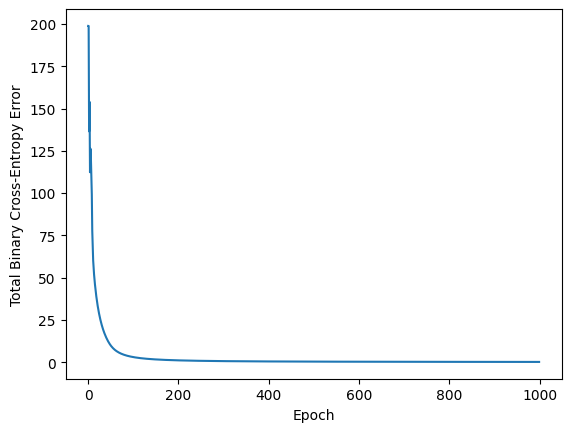

In [14]:
with torch.inference_mode():
    prediction = model(test_example)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
binary_output = 0;
for value in prediction:
    binary_output = int(torch.round(value))
    rounded_prediction.append(binary_output)

tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Y_test:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

print("True positives: ", tp)
print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))


plt.plot(loss_over_time)
plt.xlabel("Epoch")
plt.ylabel("Total Binary Cross-Entropy Error")